In [1]:
#First attempt at implementing a basic GTN... 

In [2]:
import numpy as np
import pandas as pd
import higher
import matplotlib.pyplot as plt
import tqdm


plt.style.use('ggplot')

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

#Scale data to have mean 0 and variance 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Split the data set into training and testing 

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,y,test_size=0.2,random_state=2)


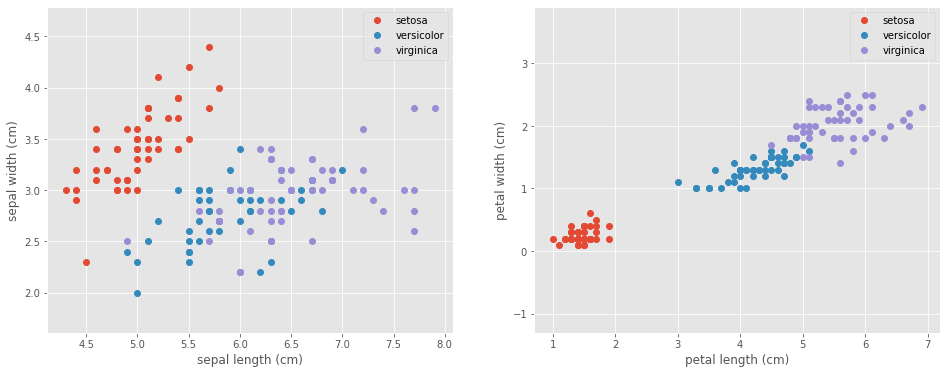

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend();

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

In [6]:
class Model(nn.Module):
    def __init__(self,input_dim):
        
        super().__init__()
        self.layer1 = nn.Linear(input_dim,50)
        self.layer2 = nn.Linear(50,50)
        self.layer3 = nn.Linear(50,3)
        
        #Question: How to implement weight normalization?
        
        
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x),dim=1)
        return x


In [7]:
model = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()
EPOCHS = 100
loss_list = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = criterion(y_pred,y_train)
    loss_list[epoch] = loss.item()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

    #Record accuracy on training (or test?) set
    with torch.no_grad():
        y_pred = model(X_train)
        correct = (torch.argmax(y_pred,dim=1) == y_train).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()
        
        
    
print(accuracy_list)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 414.34it/s]

[0.64166665 0.72500002 0.75       0.75833333 0.75833333 0.80000001
 0.81666666 0.83333331 0.84166664 0.875      0.875      0.875
 0.85833335 0.88333333 0.91666669 0.93333334 0.93333334 0.95833331
 0.96666664 0.96666664 0.96666664 0.96666664 0.96666664 0.97500002
 0.96666664 0.95833331 0.95833331 0.96666664 0.97500002 0.97500002
 0.99166667 0.98333335 0.98333335 0.98333335 0.98333335 0.98333335
 0.98333335 0.99166667 0.99166667 0.98333335 0.98333335 0.99166667
 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667
 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667
 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667
 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667
 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667
 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667
 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667
 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667 0.99166667


In [8]:
#Reparametrisation of nn.Linear
class reparam_Linear(nn.Module):
    
    def __init__(self,indim,outdim,bias=True):
        super().__init__()
        self.fc1=nn.Linear(indim,outdim,bias=bias) #params are v
        self.scale = nn.Parameter(torch.tensor([1.])) #param is scale
        
        if bias is False:
            self.bias = 0.0
        else:
            self.bias = self.fc1.bias
        
    def forward(self,x):
        
        tem = (torch.sum(self.fc1.weight**2,dim=1))**0.5 #normalize rows
        scale_vector = self.scale/tem #components are scale*v/norm(v) for each weight vector 
   
        return scale_vector*(self.fc1(x)) + (1-scale_vector)*self.bias #self.bias is either 0 or self.fc1.bias 


In [ ]:
#Testing the above cell
x=torch.tensor([1.,1.,1.])
y=torch.tensor([1.,1.])
crit = nn.MSELoss()
b=reparam_Linear(indim=3,outdim=2,bias=False)
opt = torch.optim.SGD(b.parameters(),lr=0.01)


for k in range(100):
    
    loss = crit(y,b(x))
    opt.zero_grad()
    loss.backward()
    print(b.fc1.weight)
    opt.step()

    for w in b.parameters():
        print(w)
        input()
    input('done')

In [184]:
#GTN generator (to generate synthetic data)
from torch.distributions.multivariate_normal import MultivariateNormal
import itertools
class Generator(nn.Module):
    
    def __init__(self,wdim,reparam=False):
        super().__init__()
        
        self.lr = nn.Parameter(torch.tensor([0.01]))
        
        if reparam is False:
        
            self.Fc1 = nn.Linear(wdim,wdim)
            self.Fc2 = nn.Linear(wdim,wdim)
            self.Fc3 = nn.Linear(wdim,4) #4 is the x-dim of our data
        
        else:

            #With parametrisation
            self.Fc1 = reparam_Linear(wdim,wdim)
            self.Fc2 = reparam_Linear(wdim,wdim)
            self.Fc3 = reparam_Linear(wdim,4)
      
    def forward(self,w): #w is y,z 
        w=self.Fc1(w)
        w=self.Fc2(w)
        w=self.Fc3(w)
        lr=1.0*self.lr
        return w,lr
    
    def base_params(self):
        return chain(*(m.parameters() for m in [self.Fc1, self.Fc2,self.Fc3]))

    def hyper_params(self):
        return [self.lr]
    
    
    
    
    

    
    
# g=Generator(10)

# for w in g.parameters():
#     print(w)
#     input()

In [133]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(1, 512)
        self.fc2 = nn.Linear(512, 264)
        self.fc3 = nn.Linear(264, 128)
        self.fc4 = nn.Linear(128, 964)

    def forward(self, y0):
        y1 = self.relu(self.fc1(y0))
        y2 = self.relu(self.fc2(y1))
        y3 = self.relu(self.fc3(y2))
        return self.fc4(y3)

    def base_params(self):
        
        return [m.parameters() for m in [self.fc1, self.fc2]]
        
        #return itertools.chain(m.parameters() for m in [self.fc1, self.fc2])

    def classifier_params(self):
        
        return [m.parameters() for m in [self.fc3, self.fc4]]
        #return itertools.chain(m.parameters() for m in [self.fc3, self.fc4])
        

In [135]:

model=MyModel()
print(model.base_params())
input()
torch.optim.SGD([
    {'params': model.base_params()},
    {'params': model.classifier_params(), 'lr': 1e-3}
], lr=1e-2, momentum=0.9)

[<generator object Module.parameters at 0x7f7e2a32dac0>, <generator object Module.parameters at 0x7f7e2a32dcf0>]


KeyboardInterrupt: Interrupted by user

In [177]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1,1)
        
    def forward(self,x):
        return self.fc1(x)

    def base_params(self):
        return chain(*(m.parameters() for m in [self.fc1]))
    


In [178]:
model=MyModel()
optimizer = torch.optim.SGD([{'params': model.base_params(),'lr': 0.01}])
print(model.parameters())
print(chain(model.parameters()))
print(itertools.chain(model.parameters()))

<generator object Module.parameters at 0x7f7e2a31d820>


In [10]:
#Can probably wrap this in something later, but just trying to get started...
class Learning_Rate(nn.Module):
    
    def __init__(self,lr=0.01):
        super().__init__()
        self.lr = nn.Parameter(torch.tensor([lr]))
        
    def forward(self,loss): #takes as input...
        return self.lr*loss #
    


In [11]:
#Sample data for the generator, for the specifc dataset above...
class Data_sampler:
    """"Gets us y,z in appropriate shape"""
    
    batch_size = 120
    a = torch.tensor([0, 1, 2])
    p = torch.tensor([1/3,1/3,1/3])
    
    def __init__(self,zdim):
        
        
        index = self.p.multinomial(num_samples=self.batch_size, replacement=True)
        self.ydata = self.a[index]
        
        m = MultivariateNormal(torch.zeros(zdim), torch.eye(zdim))
        self.zdata = m.sample((self.batch_size,))
        
        self.wdata = torch.cat((self.zdata,self.ydata.view(-1,1)),dim=1)


In [190]:
#This block trains the generator g
import time
outer_epochs=1000
inner_epochs=32

zdim=10 #dimension of noise we pass to generator
g = Generator(wdim=zdim+1,reparam=False) #initialize generator and outer optimizer
#outer_opt = torch.optim.Adam(g.parameters(),lr=0.001)



outer_opt = torch.optim.Adam([
                {'params': g.base_params(),'lr': 0.001},
                {'params': g.hyper_params(), 'lr': 0.0001}
            ])#, lr=1e-2, momentum=0.9)


# for p in outer_opt.param_groups:
#     print(p['lr'])
#     input()
    
# input('done')


# LR=Learning_Rate(lr=0.01) 
# LR_opt = torch.optim.SGD(LR.parameters(),lr=1e-6)

t1=time.time()
for kl in tqdm.trange(outer_epochs):
    
#     #Initialize new model (and optimizer). (Currently fixed architecture)
#     model = Model(X_train.shape[1]) 
#     inner_opt = torch.optim.Adam(model.parameters(),lr=0.01) #Want to meta learn the inner learning rate

    #Sample batch of data for inner training (i.e. sample label ydata and noise vector zdata, which gives input x as x=g(y,z))
    #where wdata (equiv to) (ydata,zdata)
    d = Data_sampler(zdim=zdim)
    wdata = d.wdata
    ydata = d.ydata
    xdata,lr = g(wdata) #    #Forward through generator to get synthetic data. i.e. (xdata,ydata) is the synethetic data

    
     #Initialize new model (and optimizer). (Currently fixed architecture)
    model = Model(X_train.shape[1]) 
    inner_opt = torch.optim.Adam(model.parameters(),lr=0.01) #Want to meta learn the inner learning rate
        
    #Inner update:
    with higher.innerloop_ctx(model, inner_opt) as (fmodel, diffopt):

        
        for p in diffopt.param_groups:
            p['lr']=lr
   
        for k2 in range(inner_epochs): #train model for k2 gd steps
            y_pred = fmodel(xdata) #depends on g parameters     

            #inner_loss = LR(criterion(y_pred,ydata)) #loss is learning_rate*(usual_loss)
            inner_loss = criterion(y_pred,ydata) #loss is learning_rate*(usual_loss)
            diffopt.step(inner_loss) #So now we have taken gradient step; depends on g weights, want it to depend on lr-weight...
            
    #Outer update:
    #Now assess model on REAL data and backpropagate through the generator's weights
    y_pred = fmodel(X_train) #fmodel is a function of the generator's weights 
    meta_loss = criterion(y_pred,y_train)    
    outer_opt.zero_grad()
    #LR_opt.zero_grad()
    meta_loss.backward()
    outer_opt.step()
    
    
input('about to check whether lr gradients computed')
for param in g.parameters():
    print(param)
    print(param.grad)
    input()
    break
    
print(lr)
print(g.lr)
input('done')

    
    
    #LR_opt.step()
    
# for w in LR.parameters():
#     print(w)
#     print(w.grad)
# input()

t2=time.time()
print((t2-t1))

#lr=0.0151

100%|███████████████████████████████████████| 1000/1000 [02:32<00:00,  6.55it/s]


about to check whether lr gradients computed
Parameter containing:
tensor([0.0151], requires_grad=True)
tensor([-0.0245])

tensor([0.0151], grad_fn=<MulBackward0>)
Parameter containing:
tensor([0.0151], requires_grad=True)
done
172.2499861717224


In [199]:
#Now, let's train a model on generated (synthetic) data instead of real data 

import tqdm

model = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(),lr=g.lr.item()) #Used the learned learning rate...

criterion = nn.CrossEntropyLoss()
EPOCHS = inner_epochs
loss_list = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    
   # y_pred = model(X_train)
    #Get synthetic data
    d = Data_sampler(zdim=zdim)
    wdata = d.wdata
    ydata = d.ydata
    xdata,_ = g(wdata) #synthetic data. i.e. (xdata,ydata)
    
    
    y_pred = model(xdata)
    loss = criterion(y_pred,ydata)
    loss_list[epoch] = loss.item()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
#     for w in model.parameters():
#         print(w)
#         input()
#         break
    

    #Record accuracy on training (or test?) set
    with torch.no_grad():
        y_pred = model(X_train)
        correct = (torch.argmax(y_pred,dim=1) == y_train).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()
        
        
    
print(accuracy_list)


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 300.89it/s]

[0.64999998 0.64999998 0.64999998 0.64999998 0.64999998 0.64999998
 0.64999998 0.64999998 0.65833336 0.76666665 0.82499999 0.92500001
 0.94999999 0.96666664 0.95833331 0.94166666]


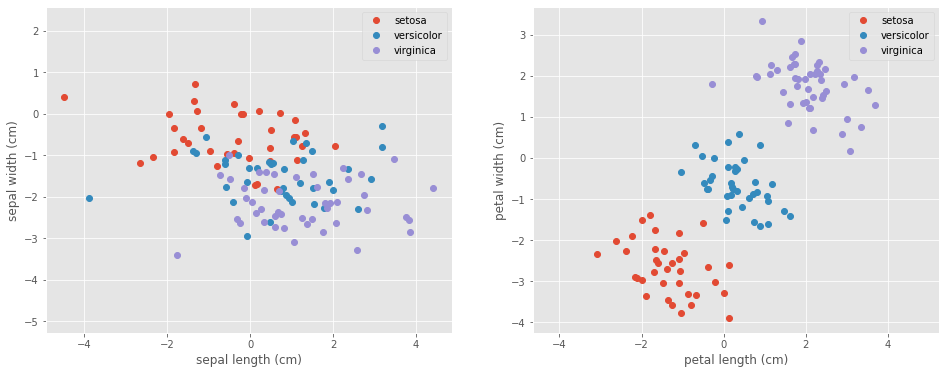

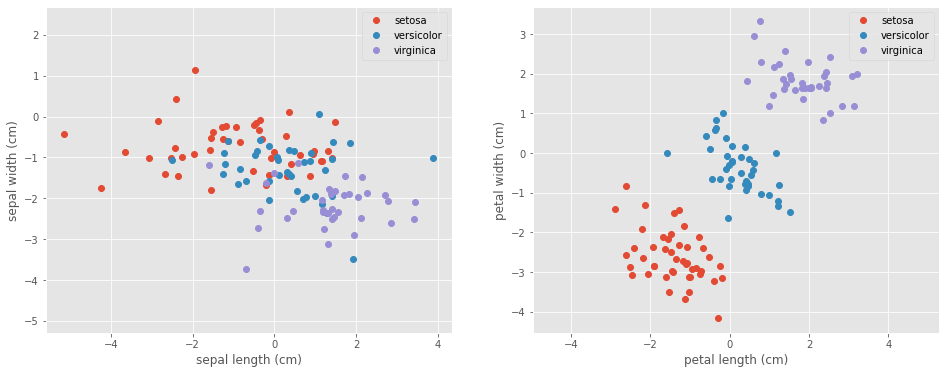

In [27]:
#Let's investigate what generated samples look like
for _ in range(2):

    #Generate a sample
    d = Data_sampler(zdim=zdim)
    wdata = d.wdata
    ydata = d.ydata
    xdata = g(wdata) #synthetic data. i.e. (xdata,ydata)

    #Convert it to format for plotting
    xdata = xdata.detach().numpy()
    ydata = ydata.numpy()




    #Now need to replace X and y by xdata and ydata resp:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    for target, target_name in enumerate(names):
        X_plot = xdata[ydata == target]
        ax1.plot(X_plot[:, 0], X_plot[:, 1], 
                 linestyle='none', 
                 marker='o', 
                 label=target_name)
    ax1.set_xlabel(feature_names[0])
    ax1.set_ylabel(feature_names[1])
    ax1.axis('equal')
    ax1.legend();

    for target, target_name in enumerate(names):
        X_plot = xdata[ydata == target]
        ax2.plot(X_plot[:, 2], X_plot[:, 3], 
                 linestyle='none', 
                 marker='o', 
                 label=target_name)
    ax2.set_xlabel(feature_names[2])
    ax2.set_ylabel(feature_names[3])
    ax2.axis('equal')
    ax2.legend();
    

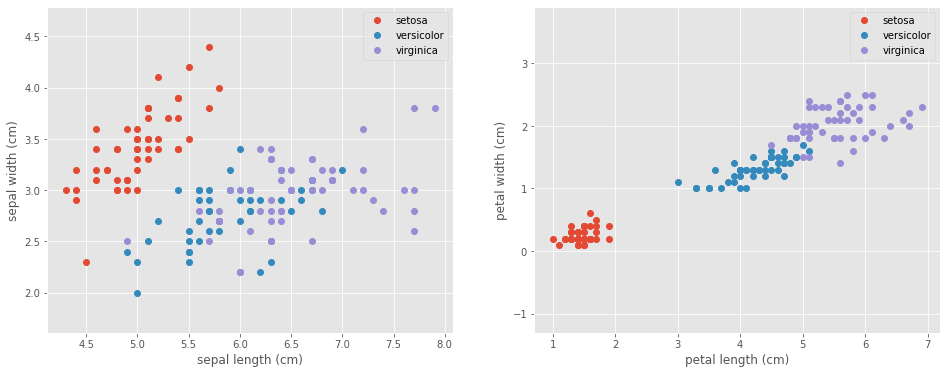

In [74]:
#Compare synthetic data above to the real samples below

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend();